In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from config import settings
from src.data import datamodule as dm
from pathlib import Path
from src.model.transformation import (FromBuffer , 
                                      CutPSD, LogTransform , NormLayer , SqueezeLayer,
                                      UnsqueezeLayer)


import matplotlib.pyplot as plt
from torch import nn 
from src.data.utils import print_database_overview, load_all_from_db 
from src.model.prepared_queries import view_melt_welch_only


In [4]:
db_path = Path(settings.path.processed, 'norther3.db')
assert db_path.exists(), f"Database not found at {db_path}"
print_database_overview(db_path)
meta_data = load_all_from_db(db_path, 'metadata')
frequency_axis = FromBuffer()(meta_data.loc[0,'frequency_axis'])

SQLite Database Overview
Table: processed_data - id, timestamp, turbine_name, Welch_X, Welch_Y, Welch_Z, RMS_X, RMS_Y, RMS_Z, RollingAverage_X, RollingAverage_Y, RollingAverage_Z, Range_X, Range_Y, Range_Z, Mean_X, Mean_Y, Mean_Z
Table: sqlite_sequence - name, seq
Table: metadata - frequency_axis, sample_rate, window_size, processing_method
Table: scada - timestamp, mean_windspeed, min_windspeed, max_windspeed, std_windspeed, mean_yaw, min_yaw, max_yaw, std_yaw, mean_power, min_power, max_power, std_power, mean_pitch, min_pitch, max_pitch, std_pitch, mean_rpm, min_rpm, max_rpm, std_rpm, mean_winddirection, min_winddirection, max_winddirection, std_winddirection, mean_NAC_ACC_Z, min_NAC_ACC_Z, max_NAC_ACC_Z, rms_NAC_ACC_Z, rms1p_NAC_ACC_Z, mean_NAC_ACC_FA, min_NAC_ACC_FA, max_NAC_ACC_FA, rms_NAC_ACC_FA, rms1p_NAC_ACC_FA, mean_NAC_ACC_SS, min_NAC_ACC_SS, max_NAC_ACC_SS, rms_NAC_ACC_SS, rms1p_NAC_ACC_SS, mean_ti, pred_Mtn_legacy, relative_wind_dir, pred_Mtn_dnn, Mean_muY, CoV, std_NAC_ACC

/tmp/ipykernel_650422/1054908431.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_data_C01.query('timestamp > "2023-06-01" and timestamp < "2023-08-10"', inplace=True)


<Axes: xlabel='timestamp'>

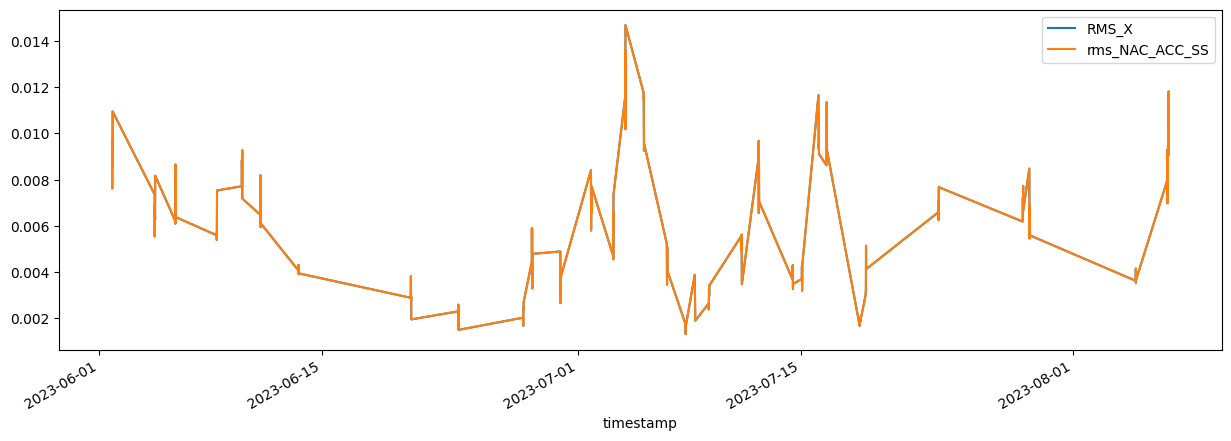

In [5]:
import sqlite3
import pandas as pd

# Connect to the SQLite database
conn = sqlite3.connect(db_path)

# SQL query to merge the required columns from processed_data and scada
query = """
SELECT 
    p.timestamp, 
    p.turbine_name, 
    p.RMS_X, 
    s.rms_NAC_ACC_SS
FROM 
    processed_data p
LEFT JOIN 
    scada s
ON 
    p.timestamp = s.timestamp 
    AND p.turbine_name = s.turbine_name
WHERE 
    p.RMS_X IS NOT NULL 
    AND s.rms_NAC_ACC_SS IS NOT NULL;
"""

# Execute the query and load the result into a pandas DataFrame
merged_data = pd.read_sql_query(query, conn)
merged_data['timestamp'] = pd.to_datetime(merged_data['timestamp']).dt.tz_localize(None)
merged_data_C01 = merged_data[merged_data['turbine_name'] == 'NRTC01']
merged_data_C01.query('timestamp > "2023-06-01" and timestamp < "2023-08-10"', inplace=True)
merged_data_C01.plot(x='timestamp', y=['RMS_X', 'rms_NAC_ACC_SS'], figsize=(15, 5))


In [6]:
from src.data.utils import get_statistic
from src.utils.rich_utils import print_stats_as_table

import numpy as np
statistics = get_statistic(db_path,['Welch_X', 'Welch_Y', 'Welch_Z', 'RollingAverage_X', 'RollingAverage_Y', 'RollingAverage_Z'],
              [np.max,np.min,np.std,np.mean], 'processed_data',
              timestamp_range=('2023-01-01', '2024-01-01'))
# let's apply a log transformation to the statistics that contain 'Welch' 
for key,item in statistics.items():
    if 'Welch' in key:
        for stat,values in item.items():
            item[stat] = np.log(values)
print_stats_as_table(statistics)



                Statistics Table                 
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓
┃ Column Name      ┃ Statistic ┃          Value ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━┩
│ Welch_X          │ max       │       6.603327 │
│ Welch_X          │ min       │     -17.611923 │
│ Welch_X          │ std       │     0.86432964 │
│ Welch_X          │ mean      │     -2.4800177 │
│ Welch_Y          │ max       │       7.549939 │
│ Welch_Y          │ min       │     -18.384657 │
│ Welch_Y          │ std       │     0.34529474 │
│ Welch_Y          │ mean      │     -2.4430842 │
│ Welch_Z          │ max       │      2.2734365 │
│ Welch_Z          │ min       │     -17.452734 │
│ Welch_Z          │ std       │     -4.0997796 │
│ Welch_Z          │ mean      │     -6.0021515 │
│ RollingAverage_X │ max       │     0.07200729 │
│ RollingAverage_X │ min       │    -0.06929287 │
│ RollingAverage_X │ std       │   0.0064177564 │
│ RollingAverage_X │ mean      │  2.8434362e-08 │
│ RollingAverage_Y │ max       │     0.08819653 │
│ RollingAverage_Y │ min       │    -0.08796526 │
│ RollingAverage_Y │ std       │    0.005357963 │
│ RollingAverage_Y │ mean      │ -2.6041715e-08 │
│ RollingAverage_Z │ max       │    0.010081319 │
│ RollingAverage_Z │ min       │   -0.009372458 │
│ RollingAverage_Z │ std       │  0.00059588684 │
│ RollingAverage_Z │ mean      │  1.0569516e-08 │
└──────────────────┴───────────┴────────────────┘

In [8]:

df_welch = pd.read_sql_query('SELECT * from processed_data', conn)
df_dem = pd.read_sql_query('SELECT * from dem', conn)

In [9]:
df_dem

,id,timestamp,turbine_name,Welch_X,Welch_Y,Welch_Z,RollingAverage_X,RollingAverage_Y,RollingAverage_Z,DEM,mean_windspeed,mean_power,mean_pitch,std_pitch,mean_rpm,std_rpm,caseID
0,23125,2023-01-28 11:00:00+00:00,NRTC01,b'\x1a\xea\x8f;n\xce\x8d:J\xb9f:$\x97\x80:\x94...,b'\xb3\x0b\xa9<\xd4\x9e\xa6;*\xec\xa6:\xcb\xce...,b'\xed:W9\xc2\x99\xd48\xaa \xc07h\x9c\xa57<;.8...,b'.\x95\xed:\x0f\x19\xfc:\x8d\xd7|:\x9e\x02\x1...,b'\x01\xcc\xe9\xbb4}_\xbb\x046\x00;\xee\xb5\xd...,b'pm?:\xe8k\xbf9\xdc-0\xb9^\xcc%\xba\xb9\xa3K\...,4.742389e+05,1.9870,-93.9896,20.0000,NaN,0.0000,NaN,Missing SCADA: SCADA required to define cases ...
1,23126,2023-01-28 11:10:00+00:00,NRTC01,b'\n\xd22:\xc3\xc20:\x8c\x00R:\xe3\xf8N:\xec\x...,b'\x8c\xacE:\xc2\x19F:\xa5\x99\xb6:\x97X\xc3:\...,b'\xae\xb0\xc98\xa4(\x7f8\xbe\xdb\xee7\xfa\xe5...,b'\xf1\x001\xba\x95\x1f/:\x91\x82\xc3:\x83\xa2...,b'+\xd4F\xb9#\x8a\r:=7\xa2:.H\xc0:\x1a\xc0s:\x...,b'\x1cO%7\xe6\xe1\x1f\xb8\xf3P\x85\xb8V}\xb6\x...,6.030971e+05,2.8262,-93.1894,20.0000,NaN,0.0000,NaN,Missing SCADA: SCADA required to define cases ...
2,23127,2023-01-28 11:20:00+00:00,NRTC01,b'{h3<\x14n\xd4;?\x8br;W\xb6\x80;\xde\xb5\x83;...,b'\xa1<\xf9;q\xc1\xa6;97x;\xa7\xa5\xcd;\x95S\x...,b'\xf6\xee\x9e9Os\x059\x1d\x1738\xf7\xdd\xac8\...,b'@\xa9\x079\xbc!\xb3:\xf8}\xf9:l\xc6\xd2:b\xd...,b'\'\x96n;\x0b\xd1J;\xf4m\x99:\xb6\xcc\xb8\xba...,b'\xc7\x02\xbd\xb9\xe8\xbe\x91\xb9\xa8\\\x9b\x...,5.024615e+05,3.7727,-95.6594,20.0000,NaN,0.5000,0.258199,Missing SCADA: SCADA required to define cases ...
3,23128,2023-01-28 11:30:00+00:00,NRTC01,b'\x1eo[<\xa8\xeb#<\xb3\x87\xea;\xf4>\xea;\'\x...,b'\xe3d\x98;1o\x98;>\x12\xac;+\x17\xbe;\xcb;\x...,b'){\x0e9m\xb1\xbb8\x90\xc7K8f\xec\x8684\xb5z8...,"b'AJ\x82\xbaf\xc1~\xbb;\xcc\xa3\xbbe\x08w\xbb,...",b'\xde\xe3\xd1:\x9b\xe5c;\x07Qz;`j);\x0ek\xe09...,b'!w\'\xb9\xa1\xfd\xce\xb96\x00\xe9\xb9\xeb\xf...,4.843187e+05,4.4882,-93.4294,20.0000,NaN,1.0100,0.192094,Missing SCADA: SCADA required to define cases ...
4,23129,2023-01-28 11:40:00+00:00,NRTC01,b'\xfc\x83\\;\xdf\x92n;\xae\x93\xa3;\xff\xb7\x...,b'\x7f\x86\xfa?\xce}\x8f?\xb6\xc8!>\xf5\x11\xc...,b'\xf9\xdb\xa5<\x01\xcfB<\x00\x1a\xe0:\xbe\xa4...,b'bZ\xc5\xbb\x85\x84\x9f\xbb\x90\x14\xa6\xba\x...,b'\xda\x7f\xa4:0\xbe\xfb\xba%a\x86\xbbH\xfe\x8...,b'|wz\xb9\x08\x11\xb68\xce\x05\xb39|C\xef9\x95...,1.085948e+06,5.2510,-69.8240,3.0875,7.885118,3.0356,1.495617,"Cutin, Power < 0: Turbine rotating up to 6.5RPM"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13851,112208,2023-04-21 19:10:00+00:00,NRTJ03,b'\xc38%@\xe8\xccF?\'n\\=\x8e.\xb2<\\\xcc\x8a<...,b'\x057\x80A\xff\x83\x9c@\xd3\x8e\x04?\xa3\x00...,b'\xf0\xf3d>\xb9\xed\x8c=\x00p\xe3;\xecR\xae;I...,"b'HVJ<,^\x1a<\xf4\xd8\x1f:q6\xb1\xbb\xd2\x87\x...",b'\xaf\xdc\x10:o\x16U\xbbRp\xb6\xbb:\x9c \xbb\...,b'\x976\x1d:\xb0\xc9\x02:\xa2+\x909\x02\xde\xa...,1.967300e+06,10.6615,6495.6297,-2.8534,1.156647,10.4702,0.267816,"RPM, Power < Max: Turbine speeding up to rated..."
13852,112209,2023-04-21 19:20:00+00:00,NRTJ03,b'}\x17G=\x12t =\x14\xa2\x9b<w\xde\x1a<\x9b\xa...,b'T\xef\x14A\x9d\rr@\x07.\xd8>\xcc\x1d\xd0=\xe...,b'\xb1&\xf2=\x19\x0bG=\x97\x12\xb9;Ke\xb2:\xeb...,"b'i\xc4;:!y\x82\xbb,+\xdd\xbb\xf5D\xaa\xbbnu\x...",b'\x81\x8f\xdd:\xc7\xf1\xc2:\x97\xe6C\xbb)o\x0...,b'f&/9\x1ej_\xb9?\xce)\xb9&sF:X\x99-:z\xd2\xa5...,2.194109e+06,8.4023,3748.6533,-2.4595,0.116401,9.6039,0.564450,"RPM, Power < Max: Turbine speeding up to rated..."
13853,112210,2023-04-21 19:30:00+00:00,NRTJ03,b'rf;=R\xa0\xe0<aZU<r\x0b\xb7;J\xe1\xac;P\xd1\...,b'\xf2\x96\xa3@Hu\xee?\x95\xba\xd0>U\xed\xd6=\...,b'\xbd\x1b\x85=c\xc8\xbf<y\x11\xb3;\xee\xa6\xb...,b'?;\x89:\x94!&;C\xb2p;H\xf9\x1b:\xf4\xc2_\xbb...,b'\xe6;\x1f\xbb4a\xaf\xba\xaah$\xbaE\x8e8:\x03...,b'h\xdf\xb98?z\xc78\x87]\xbd9\x9ex\t8\x16\xc6\...,1.606459e+06,8.1225,3147.7726,-2.3929,0.070349,9.0667,0.498266,"RPM, Power < Max: Turbine speeding up to rated..."
13854,112211,2023-04-21 19:40:00+00:00,NRTJ03,b'cD\xe5<\xc1\x96\xb6<\xa4c.<\xd1X%<Z\xd7\xe4;...,b'\xf2\xe8/A\x8ckn@\x8e\xb8\xf

In [ ]:
from src.data.simple_datamodule import PSDDataModule
# Initialize the DataModule
transform_func = [nn.Sequential(FromBuffer(),CutPSD(frequency_axis, (0, 2)),LogTransform())]
freq_axis_masked = transform_func[0][1].freq_axis_masked

data_module = PSDDataModule(
    dataframe=df_welch.query('timestamp > "2023-01-01" and timestamp < "2024-01-01"'),
    feature_columns=['Welch_X', 'Welch_Y', 'Welch_Z'],
    transform= transform_func*3,
    batch_size=64,
    split_ratio=0.1  # 10% validation
)

# Setup data_module
data_module.setup()



In [27]:
data_module.setup()
for b in data_module.train_dataloader():
    print(b)
    break

{'Welch_X': tensor([[ -5.3947,  -5.4411,  -5.4155,  ...,  -9.6682,  -9.5555,  -9.3246],
        [ -2.7206,  -3.5584,  -4.7511,  ...,  -6.0695,  -6.1205,  -6.3488],
        [ -2.3369,  -2.7377,  -3.5256,  ...,  -4.1369,  -4.6977,  -4.3650],
        ...,
        [ -2.1935,  -2.7297,  -3.4092,  ...,  -3.0325,  -2.8763,  -3.3509],
        [ -0.6374,  -1.2578,  -2.4849,  ...,  -3.0264,  -3.0199,  -3.0474],
        [ -8.9866,  -9.9714, -10.1006,  ..., -12.4828, -12.7023, -12.6476]]), 'Welch_Y': tensor([[ -3.2679,  -4.3463,  -5.8858,  ...,  -7.5840,  -7.4067,  -7.1955],
        [ -0.8621,  -2.1027,  -4.6089,  ...,  -4.3316,  -4.2130,  -4.3745],
        [ -0.1236,  -0.2532,  -1.6841,  ...,  -2.8661,  -3.3462,  -3.2123],
        ...,
        [ -1.3002,  -1.8921,  -2.1007,  ...,  -1.6160,  -1.7088,  -2.2284],
        [  1.6127,   0.5612,  -0.8325,  ...,  -2.2194,  -1.7687,  -1.9401],
        [ -6.1909,  -6.1731,  -6.0682,  ..., -12.2111, -12.1096, -12.4795]]), 'Welch_Z': tensor([[ -7.4161,  -8.4

In [28]:
import pytorch_lightning as pl
from src.model.backbone.multihead_AE import AutoEncoderConv, MultiModalAutoEncoder
from torch import optim
import torch
class TrainingAutoEncoderConv(pl.LightningModule):
    def __init__(self, lr: float):
        super().__init__()
        self.model = MultiModalAutoEncoder(
            input_dims= {'Welch_X': len(freq_axis_masked),
                            'Welch_Y': len(freq_axis_masked),
                            'Welch_Z': len(freq_axis_masked)},
            normalization_values=statistics,
            separated_layer=[512,128,64],
            shared_layer=[128,64,32],
        )
        self.lr = lr
        self.loss = torch.nn.MSELoss()
        self.save_hyperparameters(ignore=['model'])
        
    def forward(self, x):
        # add channel dimension to the input
        
        x = self.model(x)
        
        return x
    
    def forward_embedding(self, x):
        return self.model.encoder(x)

    def _common_step(self, batch, batch_idx, stage):

        x_hat = self(batch)
        # batch is a dictionary with the keys 'Welch_X', 'Welch_Y', 'Welch_Z' and also x_hat
        loss = sum([self.loss(x_hat[key], batch[key]) for key in batch.keys()])
        
        self.log(f'{stage}_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss
    
    def training_step(self, batch, batch_idx):
        return self._common_step(batch, batch_idx, 'train')
    
    def validation_step(self, batch, batch_idx):
        return self._common_step(batch, batch_idx, 'val')
    
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

In [30]:
from pytorch_lightning.loggers import MLFlowLogger
from pytorch_lightning.callbacks import ModelCheckpoint, RichProgressBar

mlflow_logger = MLFlowLogger(experiment_name="CAE-allturbine",
                            save_dir=settings.path.mlflow[1:])

checkpoint_callback = ModelCheckpoint(monitor='val_loss', save_top_k=1, filename='AE-{epoch:02d}-{val_loss:.2f}')
trainer = pl.Trainer(max_epochs=50, logger=mlflow_logger,
                     callbacks=[checkpoint_callback, RichProgressBar()],
                     max_time="00:00:15:30",)
model_ae = TrainingAutoEncoderConv(lr=1e-3)

trainer.fit(model_ae, data_module)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name  ┃ Type                  ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model │ MultiModalAutoEncoder │  1.3 M │ train │
│ 1 │ loss  │ MSELoss               │      0 │ train │
└───┴───────┴───────────────────────┴────────┴───────┘

Trainable params: 1.3 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.3 M                                                                                                
Total estimated model params size (MB): 5                                                                          
Modules in train mode: 77                                                                                          
Modules in eval mode: 0

Output()

`Trainer.fit` stopped: `max_epochs=50` reached.


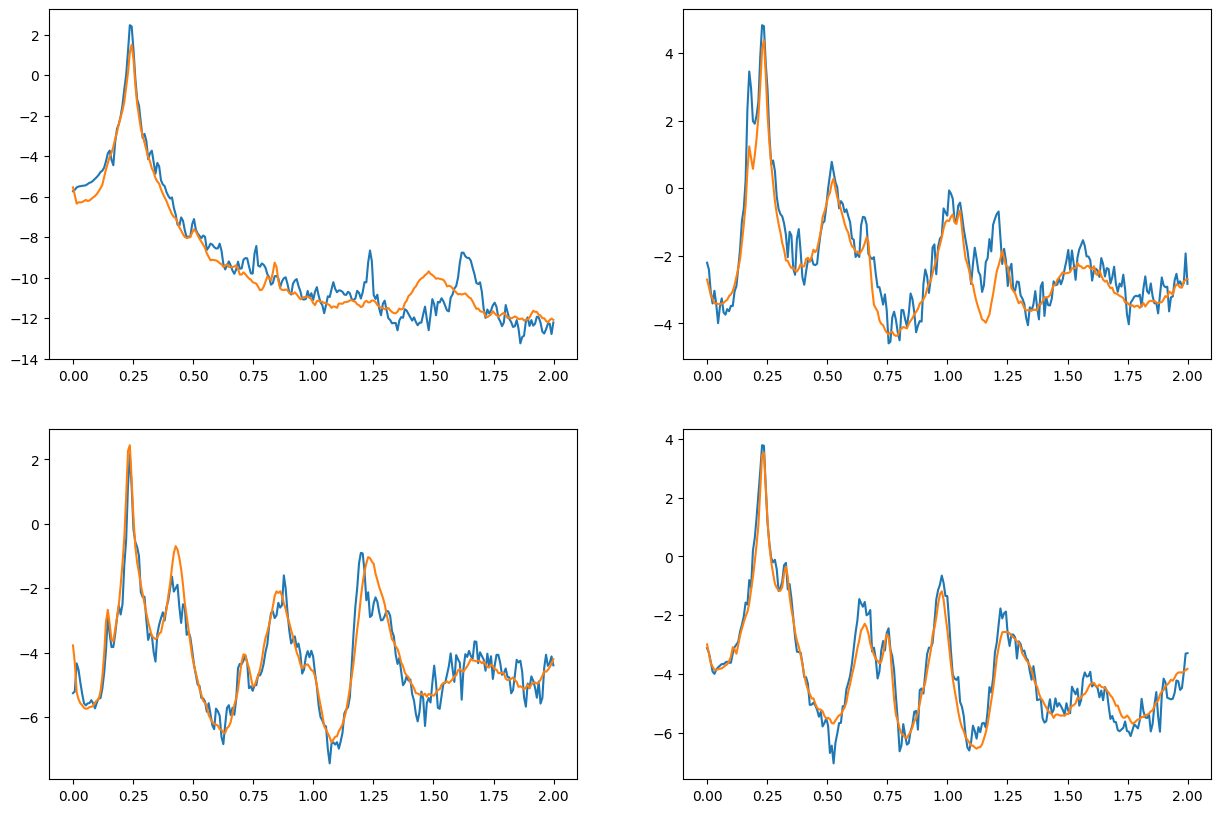

In [32]:
model_ae.to('cpu')
data = next(iter(data_module.train_dataloader()))

data_rec = model_ae(data) 
data=data['Welch_X']
data_rec = data_rec['Welch_X']
fig,ax  = plt.subplots(2,2,figsize=(15,10))
for i,(psd_in, psd_out) in enumerate(zip(data[0:4], data_rec[0:4])):
    ax[i//2, i%2].plot(freq_axis_masked, psd_in.cpu().numpy())
    ax[i//2, i%2].plot(freq_axis_masked, psd_out.cpu().detach().numpy())
plt.show()
